There are 9 hardware shift position, in each hardware position shift there are 3 repetitions. In this approach, we train all 3 repetitions of 1 hardware shift and test the rest of 8 hardware of 3 repetitions. We use 9 fold validation for this train and test.
Note: We use virtual shifting for training with Feed Forward Neural Network and Self-supervised Learning.
We only consider 5 motions: 1Flexion, 2Extension, 7Open, 8close, 9rest

1. Define necessary modules, class, functions

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from joblib import dump, load
import matplotlib.pyplot as plt
import csv
import torch
import torch.nn as nn
import torch.optim as optim
from data_loader import CustomSignalData, CustomSignalData1
from torch.autograd import Variable
from encoder import Encoder as E
from helpers import set_cmd_cb, rms_formuula, get_data, get_all_data, get_shift_data, get_operators, plot_cfs_mat, roll_data

features = ['RMS', 'MAV', 'SSC', 'ZC', 'WL']

DEVICE = torch.device("cpu")

def getFeatureMatrix(rawDataMatrix, window_size, overlap_factor):
    nChannels, nSamples = rawDataMatrix.shape
    stride = int(window_size * overlap_factor)
    num_stride = int(np.floor(nSamples/(window_size-stride)))
    featMatrix = np.zeros((nChannels*len(features),num_stride))
    # Define a dictionary that maps feature names to functions that calculate those features
    feature_functions = {
        'RMS': lambda x: np.sqrt(np.mean(x ** 2, axis=1)),
        'MAV': lambda x: np.mean(np.abs(x), axis=1),
        'SSC': lambda x: np.mean(((x[:, 1:-1] - x[:, :-2]) * (x[:, 2:] - x[:, 1:-1])) < 0, axis=1).reshape(-1, 1),
        'ZC': lambda x: np.mean((x[:, :-1] * x[:, 1:] < 0) & (np.abs(x[:, :-1] - x[:, 1:]) > 0), axis=1).reshape(-1, 1),
        'WL': lambda x: np.mean(np.abs(x[:, :-1] - x[:, 1:]), axis=1)
    }
    # Loop over the features 
    featIndex = 0
    for feature in features:
        if feature in feature_functions:
            featFunc = feature_functions[feature]
            for i in range(num_stride):
                wdwStrtIdx = i*(window_size-stride)
                if i == num_stride:
                    sigWin = rawDataMatrix[:, wdwStrtIdx:nSamples] 
                else:
                    sigWin = rawDataMatrix[:, wdwStrtIdx:(wdwStrtIdx+window_size-1)] 
                
                featValues = featFunc(sigWin)
                featValues = featValues.flatten() # Flatten featValues before assigning it to featMatrix
                featMatrix[featIndex:featIndex + nChannels, i] = featValues     
            featIndex += nChannels
    return featMatrix

class FFNN(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(FFNN, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(inputSize, 9, bias=False),
            torch.nn.Sigmoid()
        )
        self.classifer = torch.nn.Sequential(
            torch.nn.Linear(9, outputSize, bias=False),
            # torch.nn.Softmax(dim=1)
        )

    def forward(self, x, encoder=None):
        if not encoder:
            encoder = self.encoder
        z = encoder(x)
        class_z = self.classifer(z)

        return class_z

class Operator(nn.Module):
    def __init__(self, in_features, n_rotations):
        super(Operator, self).__init__()
        """
        Args:
          in_features (int): Number of input features which should be equal to xsize.
          out_features (out): Number of output features which should be equal to ysize.
        """
        self.in_features = in_features
        self.core = torch.nn.Parameter(torch.zeros(3*self.in_features**2)- 0*torch.diag(torch.rand(3*self.in_features**2)/10))
        self.core.requires_grad = True
        self.n_rotations = n_rotations
        
    def rotate_batch(self, x, d, out_features):
      rotated = torch.empty(x.shape[0], 3*out_features*out_features, device=DEVICE)
      phies = [torch.linalg.matrix_power(self.core,i).to(DEVICE) for i in range (0,self.n_rotations+0)]
      for i in range (x.shape[0]):
        rotated[i] = phies[(d[i]+0)%4].matmul(x[i]) 
      return rotated

    def forward(self, x, d):
        """
        Args:
          x of shape (batch_size, 3, xsize, xsize): Inputs.
        
        Returns:
          y of shape (batch_size, 3*xsize^2): Outputs.
        """
        z = self.rotate_batch(x, d, self.in_features)
        return z
def get_tensor(arr):
    return torch.tensor(arr, device=DEVICE,dtype=torch.float )

def rotate_batch(x, d, out_features):
    M = torch.diag(torch.ones(8)).roll(-1,1)
    used_bases = [torch.linalg.matrix_power(M,i).to(DEVICE) for i in range (8)]
    rotated = torch.empty(x.shape, device=DEVICE)
    for i in range (x.shape[0]):
        rotated[i] = used_bases[d[i]].matmul(x[i]) 
    return rotated

def clf_acc(model, loader, masks = None, encoder = None):
    model.eval()
    correct = 0
    iter = 0
    with torch.no_grad():
        for inputs, labels,_,_ in loader:
            inputs = inputs.to(DEVICE)
            if masks is not None:
                inputs = inputs * masks[:inputs.size()[0]]
            labels = labels.to(DEVICE)
            labels = labels.flatten()
            if encoder:
                pred = model(inputs, encoder)
            else:
                pred = model(inputs)
            correct += (1-torch.abs(torch.sign(torch.argmax(pred,dim = 1)- labels))).mean().item()
            iter += 1
    return correct/iter

def compute_accuracy(a, b, loader):
    a.eval()
    b.eval()
    
    correct = 0
    iter = 0
    
    with torch.no_grad():
        for inputs1, inputs2, shift1, shift2, labels, _ in loader:
            inputs1 = inputs1.to(DEVICE)
            inputs2 = inputs2.to(DEVICE)
            shift1 = -shift1.int().flatten().to(DEVICE)
            shift2 = -shift2.int().flatten().to(DEVICE)
            labels = labels.flatten().to(DEVICE)
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            y1 = a(inputs1)
            y_tr_est1 = rotate_batch(y1,shift1,6)
            y_tr1 = b(y_tr_est1)

            y2 = a(inputs2)
            y_tr_est2 = rotate_batch(y2,shift1,6)
            y_tr2 = b(y_tr_est2)

            correct += (1-torch.abs(torch.sign(torch.argmax(y_tr1,dim = 1)- labels))).mean().item() + \
                    (1-torch.abs(torch.sign(torch.argmax(y_tr2,dim = 1)- labels))).mean().item()
            iter += 1
    return correct * 0.5 / iter

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2. Train and Test at the same physical position shifting itself: 3 fold validation

In [2]:
import os
import pandas as pd
import numpy as np

subject = '26'

Fs = 1000
windowLength = int(np.floor(0.1 * Fs))  # 100ms
windowOverlap = 0.5  # 50% overlap

# Initialize empty lists to store data
X_train = [np.zeros([0, 8 * 5]) for _ in range(9)]  # Adjusting to accommodate 5 features
y_train = [np.zeros([0]) for _ in range(9)]
X_test = [np.zeros([0, 8 * 5]) for _ in range(9)]
y_test = [np.zeros([0]) for _ in range(9)]


for shift in range(0,9):
    for files in sorted(os.listdir(f'Subject_{subject}/Shift_{shift}/')):
        _, class_,_, rep_ = files.split('_')
        
        if class_ in ['1','2','7','8','9']:
            df = pd.read_csv(f'Subject_{subject}/Shift_{shift}/{files}', skiprows=0, sep=' ', header=None)
            data_arr = np.stack([np.array(df.T[i::8]).T.flatten().astype('float32') for i in range(8)])
            data_arr -= 121
            data_arr /= 255.0
            feaData = getFeatureMatrix(data_arr, windowLength, windowOverlap)
            
            # Sum across each feature separately
            num_features = 5  # Number of features
            feature_sum = np.zeros((num_features, feaData.shape[1]))

            for f in range(num_features):
                feature_sum[f] = feaData[f*8:(f+1)*8, :].sum(axis=0)
            
            if not class_.startswith('9'):
                baseline = 2 * feature_sum.sum(axis=0)[-50:].mean()
                start_ = np.argmax(feature_sum.sum(axis=0) > baseline)
                end_ = len(feature_sum.sum(axis=0)) - np.argmax(feature_sum.sum(axis=0)[::-1] > baseline) - 1
                feaData = feaData.T[start_:end_]
            else:
                feaData = feaData.T
            
            
            X_train[shift] = np.concatenate([X_train[shift],feaData])
            y_train[shift] = np.concatenate([y_train[shift],np.ones_like(feaData)[:,0]*int(class_)-1])

            for shift2 in range(9):
                if shift2 != shift:  
                    X_test[shift2] = np.concatenate([X_test[shift2],feaData])
                    y_test[shift2] = np.concatenate([y_test[shift2],np.ones_like(feaData)[:,0]*int(class_)-1])


In [3]:
print("Training dataset feature:")
print(X_train[0].shape)
print("Training dataset label:")
print(y_train[0].shape)
print("Testing dataset feature:")
print(X_test[0].shape)
print("Testing dataset label:")
print(y_test[0].shape)

Training dataset feature:
(3776, 40)
Training dataset label:
(3776,)
Testing dataset feature:
(30235, 40)
Testing dataset label:
(30235,)


2. Logistic Regression

2.1 Training accuracy

In [4]:
for shift in range(9):
    reg = LogisticRegression(penalty='l2', C=100).fit(X_train[shift], y_train[shift])
    dump(reg, f'LogisticRegression_shift_{shift}_app2_5motions_full_features.joblib')

2.2 Testing accuracy

In [5]:
accuracies_LosReg_list_s2 = [0 for _ in range(9)]
for shift in range(9):
    logRegres  = load(f'LogisticRegression_shift_{shift}_app2_5motions_full_features.joblib')
    accuracy = logRegres.score(X_test[shift],y_test[shift])
    accuracies_LosReg_list_s2[shift]= accuracy
    print(f'Accuracy of shift {shift}:')
    print(accuracy)

print(accuracies_LosReg_list_s2)

Accuracy of shift 0:
0.4769307094426989
Accuracy of shift 1:
0.4307519120617157
Accuracy of shift 2:
0.4366709668882935
Accuracy of shift 3:
0.41938273247306107
Accuracy of shift 4:
0.36140304346384644
Accuracy of shift 5:
0.413991550513955
Accuracy of shift 6:
0.5254411569590023
Accuracy of shift 7:
0.42734504474643686
Accuracy of shift 8:
0.5138108994125093
[0.4769307094426989, 0.4307519120617157, 0.4366709668882935, 0.41938273247306107, 0.36140304346384644, 0.413991550513955, 0.5254411569590023, 0.42734504474643686, 0.5138108994125093]


3.2.2.2 Accuarcy average total of 9 hardware shitfs test

In [6]:
value_average_accuracies_LosReg_s2 = sum(accuracies_LosReg_list_s2) / 9 
print(value_average_accuracies_LosReg_s2)

0.445080890662391


2.3 Plot the graph

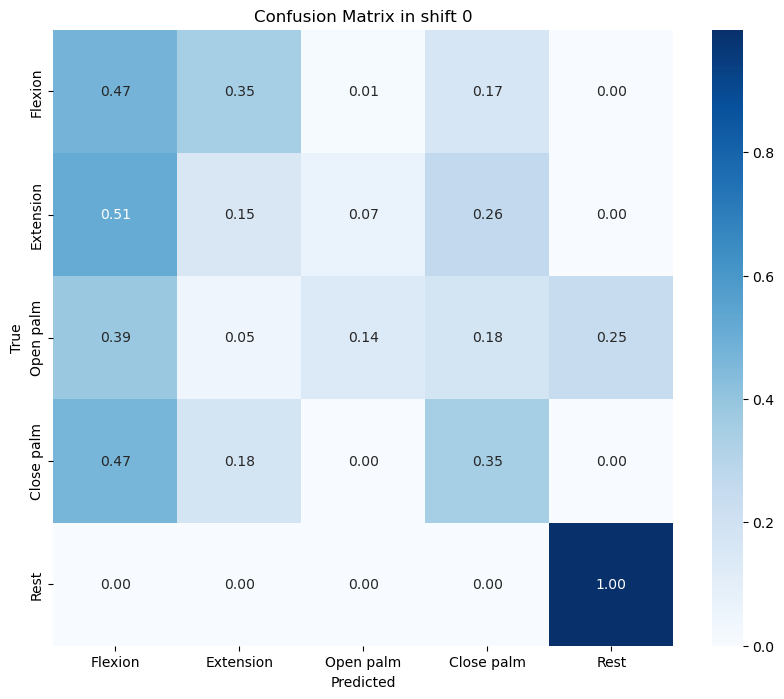

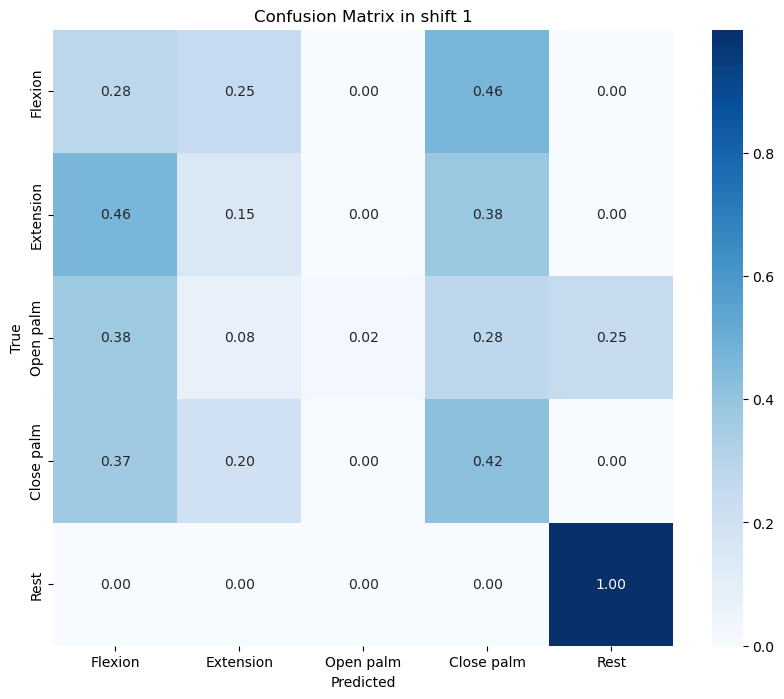

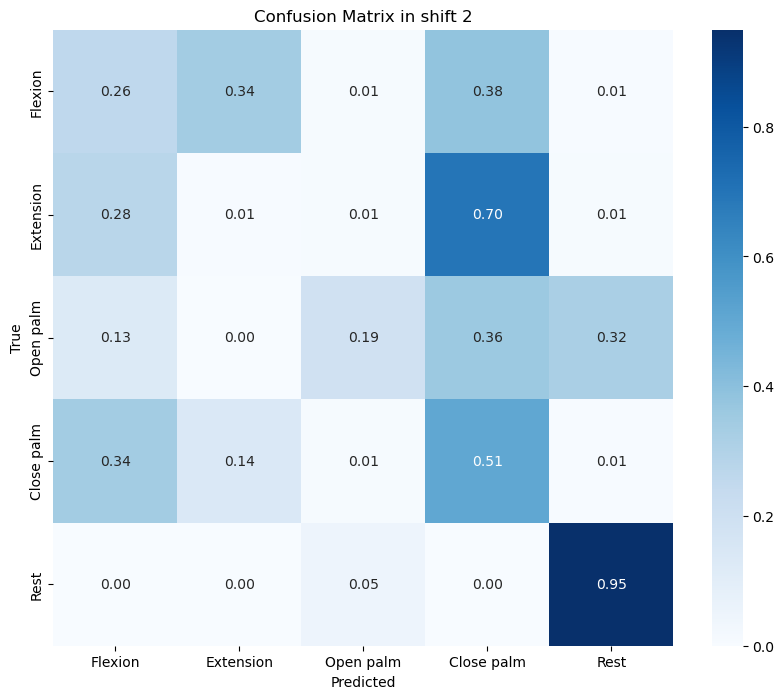

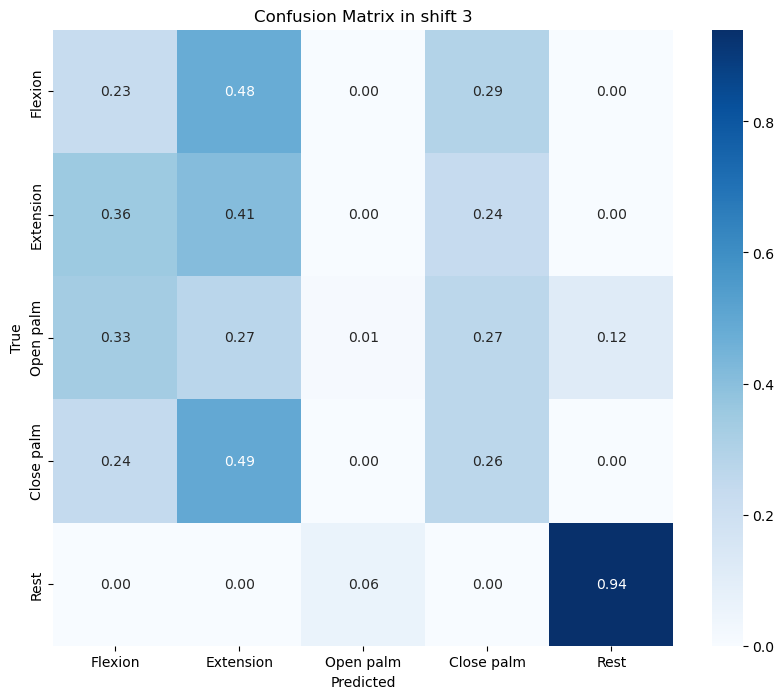

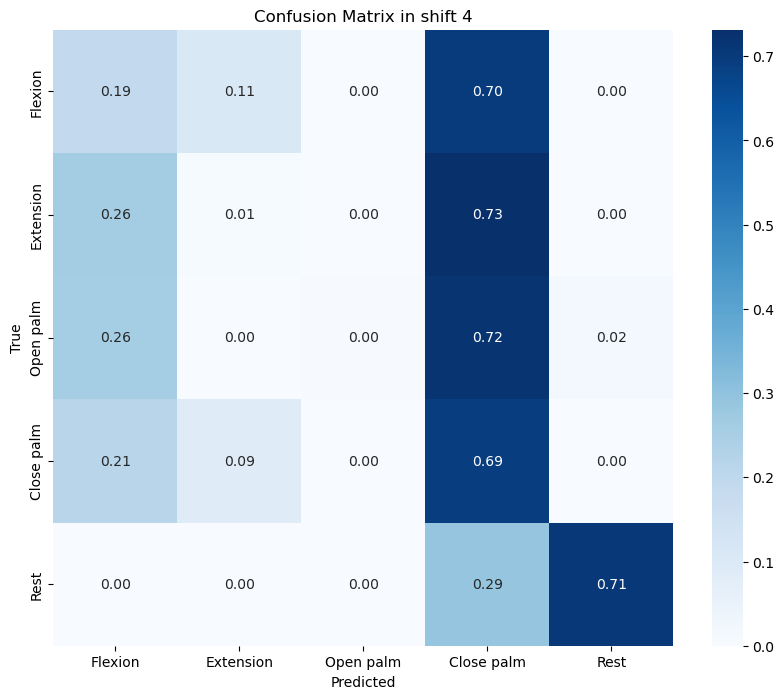

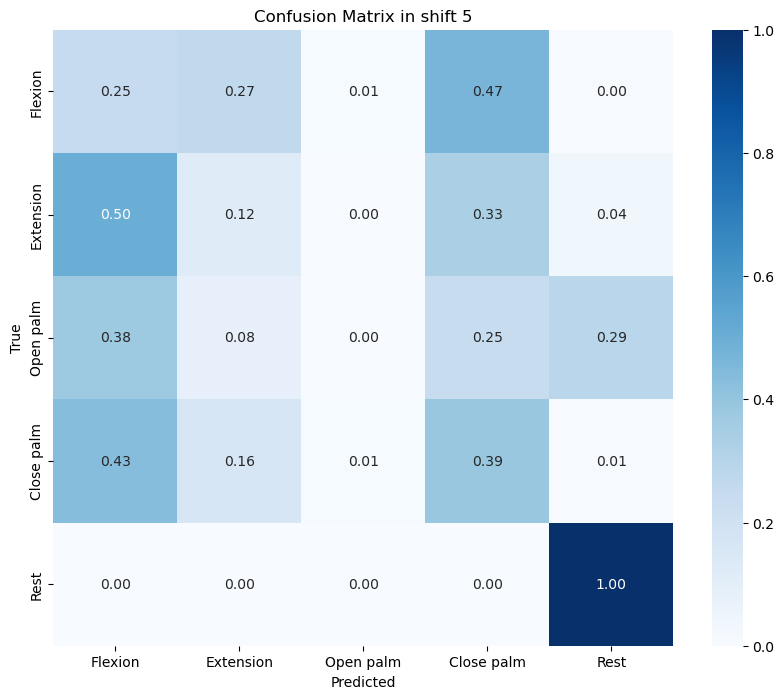

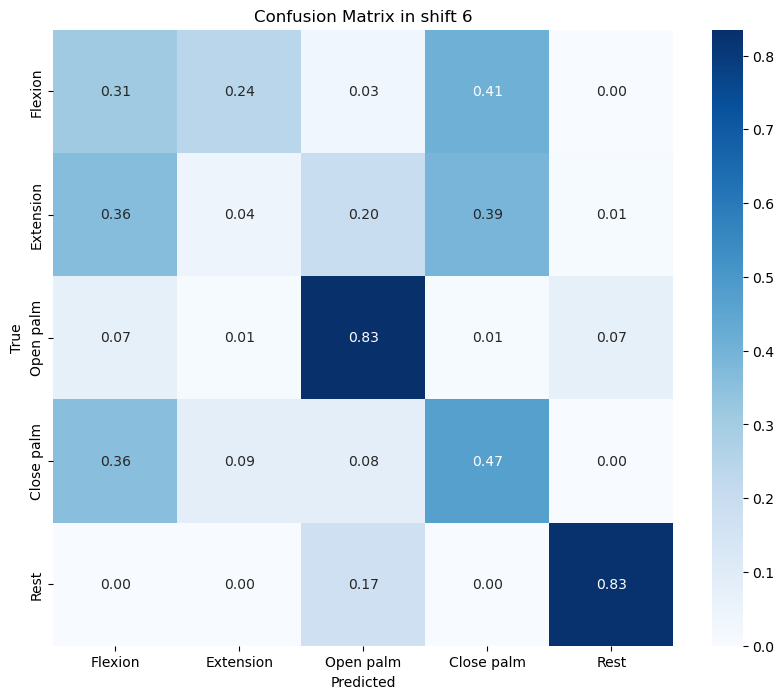

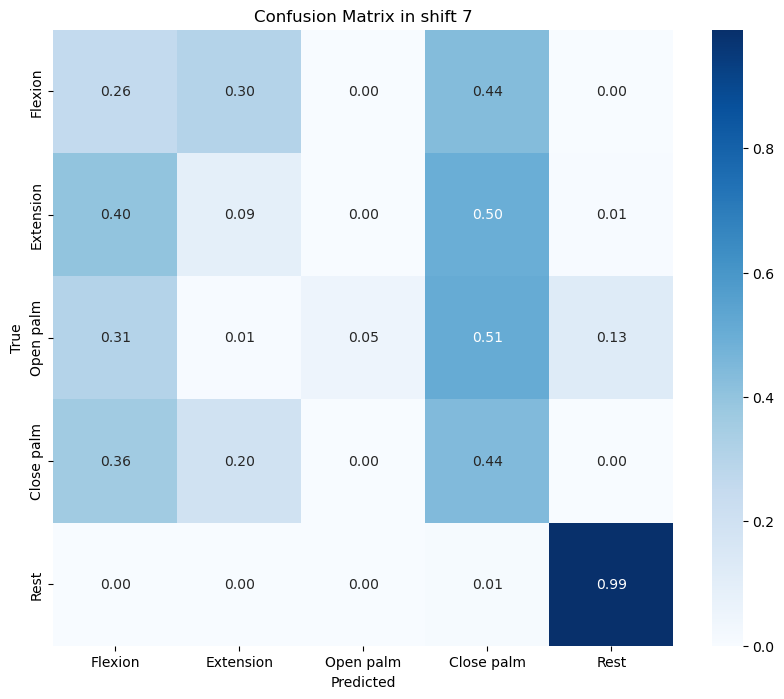

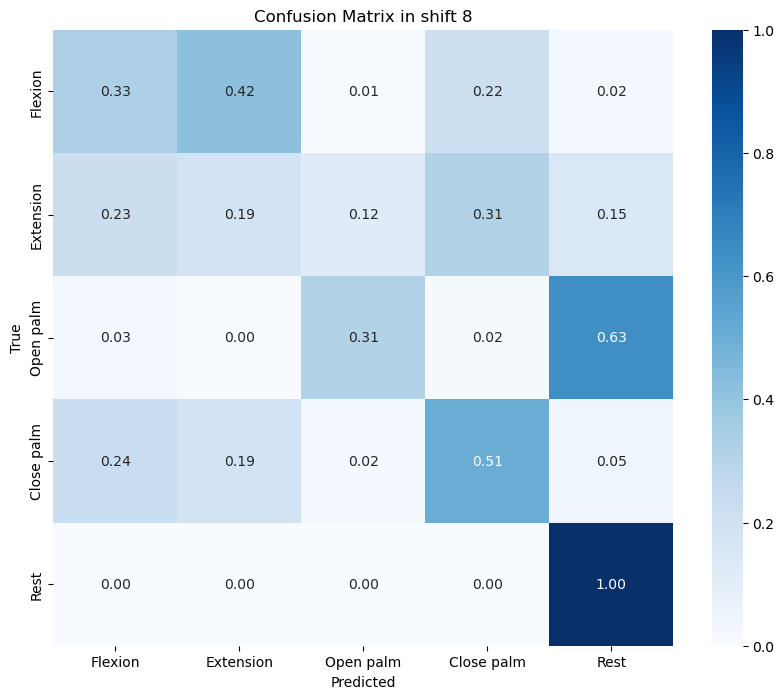

In [3]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize variables to accumulate predictions and true labels
# Define class names
class_names = ['Flexion', 'Extension', 'Open palm', 'Close palm', 'Rest']

conf_matrices_list_LogisReg = []

# Loop through shifts and folds
for shift in range(9):

    # Load the trained model
    reg = load(f'LogisticRegression_shift_{shift}_app2_5motions_full_features.joblib')

    # Make predictions on the test data
    predictions = reg.predict(X_test[shift])
        
    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_test[shift], predictions)
    conf_matrices_list_LogisReg.append(conf_matrix)

    total_samples_per_class = np.sum(conf_matrix, axis=1)
    conf_matrix_percent_LogReg = conf_matrix / total_samples_per_class[:, None]

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_percent_LogReg , annot=True, cmap='Blues', fmt='.2f', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix in shift {shift}')
    plt.show()


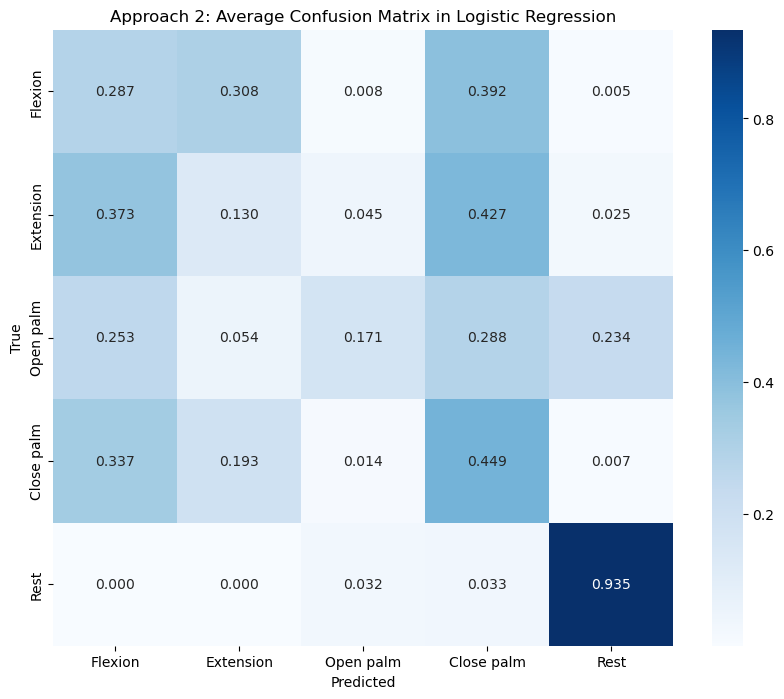

In [5]:
average_conf_matrix_LogReg = np.mean(conf_matrices_list_LogisReg, axis=0)
average_total_LogReg_samples_per_class = np.sum(average_conf_matrix_LogReg, axis=1)
average_conf_LogReg_matrix_percent = average_conf_matrix_LogReg / average_total_LogReg_samples_per_class[:, None]
# Plot the average confusion matrix
plt.figure(figsize=(10, 8))

sns.heatmap(average_conf_LogReg_matrix_percent, annot=True, cmap='Blues', fmt='.3f', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Approach 2: Average Confusion Matrix in Logistic Regression')
plt.show()

3.Feed Forward Neural Network

In [9]:
import pandas as pd
import numpy as np
import torch
import os
import seaborn as sns


def get_all_data_full_feature(X, y, v_shift=None):
    num_features = 5  # Number of features in the feature matrix
    num_channels = 8  # Number of channels

    if v_shift is None:
        all_X = np.zeros([X.shape[0], 8, num_channels * num_features], dtype='float32')
        all_y = np.zeros([y.shape[0], 8], dtype='float32')
        all_shift = np.zeros([y.shape[0], 8], dtype='int')

        for i, shift in enumerate(range(-4, 4)):
            X_i = roll_data(X, shift)
            all_X[:, i, :] = X_i
            all_y[:, i] = y
            all_shift[:, i] = shift

        return all_X.reshape(-1, num_channels * num_features), all_y.reshape(-1, 1), all_shift.reshape(-1, 1)
    else:
        shapes = [X_.shape[0] for X_ in X]
        all_shift = [np.ones(shape, dtype='int') * v_shift for (v_shift, shape) in zip(v_shift, shapes)]
        return np.concatenate(X).reshape(-1, num_channels * num_features), np.concatenate(y).reshape(-1, 1), np.concatenate(all_shift).reshape(-1, 1)


def get_shift_data_full_features(all_X, all_shift, all_y):
    num_features = 5  # Number of features in the feature matrix
    num_channels = 8  # Number of channels
    feature_dim = num_channels * num_features

    # Combine features with shift values
    all_X_shift = np.concatenate([all_X, all_shift], axis=1)
    
    # Initialize arrays with correct dimensions
    all_X1 = np.zeros_like(all_X)
    all_X2 = np.zeros_like(all_X)
    all_y_ = np.zeros_like(all_y)
    all_shift_1 = np.zeros_like(all_y)
    all_shift_2 = np.zeros_like(all_y)

    for class_label in range(9):
        class_idx = all_y.flatten() == class_label
        class_data = all_X_shift[class_idx]
        class_data_clone = class_data.copy()
        np.random.shuffle(class_data_clone)

        all_X1[class_idx] = class_data[:, :-1]
        all_X2[class_idx] = class_data_clone[:, :-1]
        all_shift_1[class_idx] = class_data[:, -1:]
        all_shift_2[class_idx] = class_data_clone[:, -1:]
        all_y_[class_idx] = class_label

    return all_X1, all_X2, all_shift_1, all_shift_2, all_y_



In [10]:
alltrainloader_list_s2 = []
triplettrainloader_list_s2 = []

for shift in range(9):
    all_X_train, all_y_train, all_shift_train = get_all_data_full_feature(X_train[shift], y_train[shift])
    all_X1_train, all_X2_train, all_shift_1_train, all_shift_2_train, all_y_shift_train = get_shift_data_full_features(all_X_train, all_shift_train, all_y_train)

    all_train_dataset = CustomSignalData(get_tensor(all_X_train), get_tensor(all_y_train))
    alltrainloader = torch.utils.data.DataLoader(all_train_dataset, batch_size = 102, shuffle=True)
    alltrainloader_list_s2.append(alltrainloader)

    triplet_train_dataset = CustomSignalData1(get_tensor(all_X1_train), get_tensor(all_X2_train), get_tensor(all_shift_1_train), get_tensor(all_shift_2_train), get_tensor(all_y_shift_train))
    triplettrainloader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size = 102, shuffle=True)
    triplettrainloader_list_s2.append(triplettrainloader)

In [11]:
print(alltrainloader_list_s2)
print(triplettrainloader_list_s2)

[<torch.utils.data.dataloader.DataLoader object at 0x764c9b10cd60>, <torch.utils.data.dataloader.DataLoader object at 0x764ba530b2b0>, <torch.utils.data.dataloader.DataLoader object at 0x764ba530a7a0>, <torch.utils.data.dataloader.DataLoader object at 0x764ba530a500>, <torch.utils.data.dataloader.DataLoader object at 0x764ba530bf70>, <torch.utils.data.dataloader.DataLoader object at 0x764ba5308b20>, <torch.utils.data.dataloader.DataLoader object at 0x764ba530a1d0>, <torch.utils.data.dataloader.DataLoader object at 0x764ba530abf0>, <torch.utils.data.dataloader.DataLoader object at 0x764ba530bcd0>]
[<torch.utils.data.dataloader.DataLoader object at 0x764ba530b1f0>, <torch.utils.data.dataloader.DataLoader object at 0x764ba53093f0>, <torch.utils.data.dataloader.DataLoader object at 0x764ba530a650>, <torch.utils.data.dataloader.DataLoader object at 0x764ba5309840>, <torch.utils.data.dataloader.DataLoader object at 0x764ba5308c70>, <torch.utils.data.dataloader.DataLoader object at 0x764ba530

3.3.2 Training Feed Forward Neural Network

In [12]:
inputDim = 40     # takes variable 'x' 
outputDim = 9      # takes variable 'y'
learningRate = 0.005

for shift in range(9):
    model = FFNN(inputDim, outputDim)
    model = model.to(DEVICE)

    crit = torch.nn.CrossEntropyLoss()
    acc_record = []
    params_clf = list(model.parameters())# + list(encoder.parameters())
    optim = torch.optim.Adam(params_clf, lr=learningRate)

    epochs = 200
    #encoder = encoder.to(device)
    for epoch in range(epochs):
        model.train()

        # Converting inputs and labels to Variable
        for inputs, labels, _, _ in alltrainloader_list_s2[shift]:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            labels = labels.long()
            labels = labels.flatten()
            outputs = model(inputs, None)
            optim.zero_grad()
            # get loss for the predicted output
            losss = crit(outputs, labels) #+ 0.001 * model.l1_regula()
            # get gradients w.r.t to parameters
            losss.backward()
            # update parameters
            optim.step()

    torch.save(model.state_dict(), f"modelwoOperator_fshift_{shift}_app2_5motions_full_features.pt")



3.3.3 Testing accuracy of Feed Forward Neural Network

In [14]:
accuracies_FFNN_list_s2 = [0 for _ in range(9)]
for shift in range(9):
    modelWOoperator = FFNN(40,9)
    modelWOoperator.load_state_dict(torch.load(f"modelwoOperator_fshift_{shift}_app2_5motions_full_features.pt")) # loaded from the file: parameters learned during training.
    modelWOoperator.eval()

    test_shift_dataset = CustomSignalData(get_tensor(X_test[shift]), get_tensor(y_test[shift]))
    testshiftloader = torch.utils.data.DataLoader(test_shift_dataset, batch_size=24, shuffle=True)
    accuracies_FFNN_list_s2[shift] = clf_acc(modelWOoperator, testshiftloader, encoder = None)


print(accuracies_FFNN_list_s2)

[0.5308496953239517, 0.5113756722098215, 0.5930224876318659, 0.5270351175299094, 0.3801483623713089, 0.44040201082587815, 0.46154866212876716, 0.4561804461756363, 0.6059800877563679]


In [15]:
value_average_accuracies_FFNN_s2 = sum(accuracies_FFNN_list_s2) / 9 
print(value_average_accuracies_FFNN_s2)

0.5007269491059452


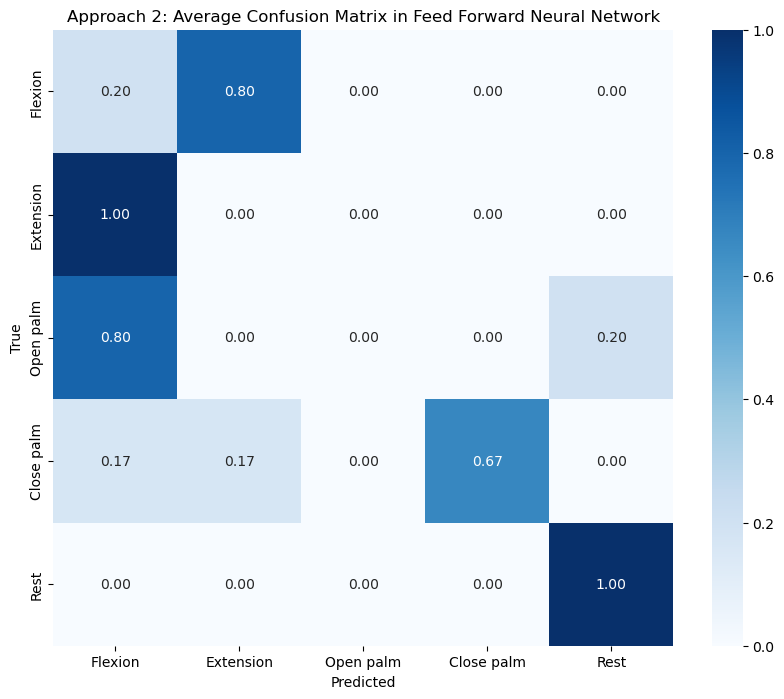

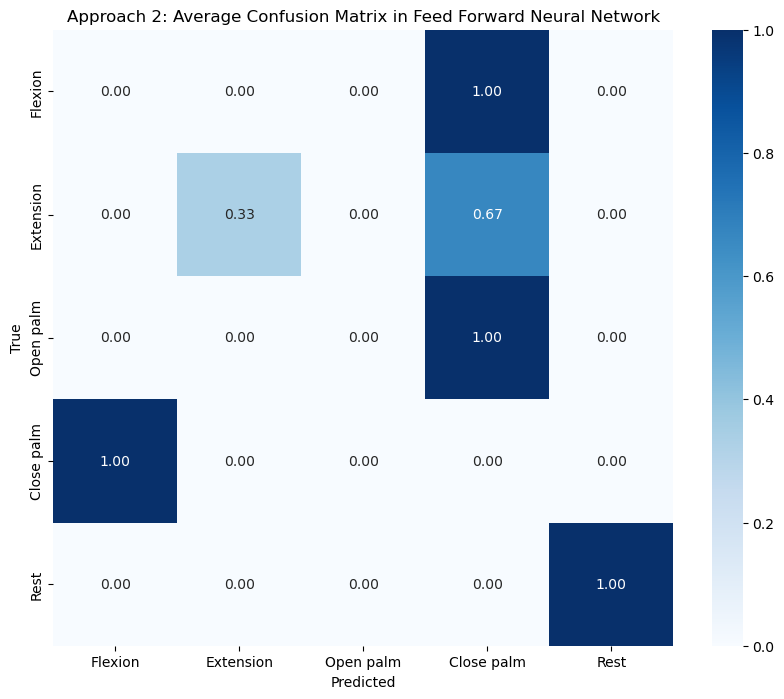

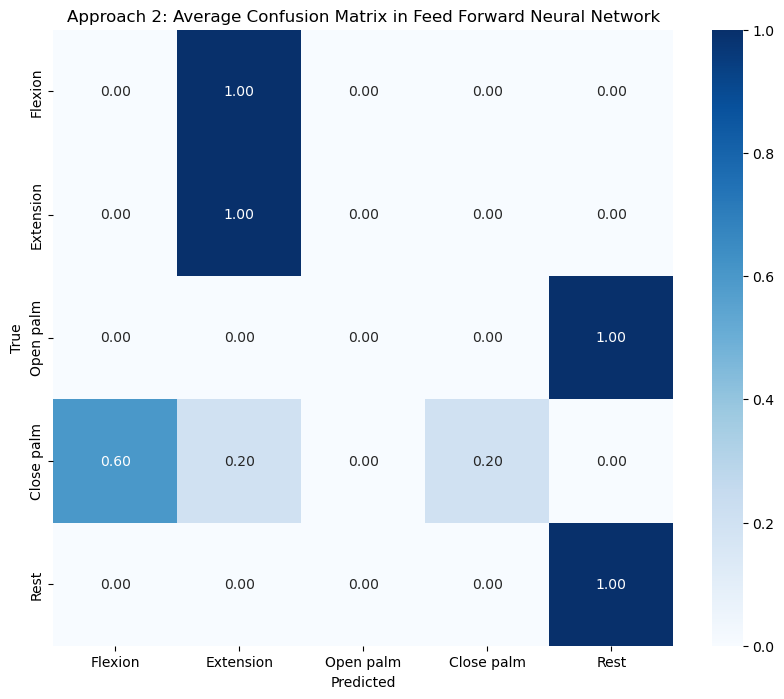

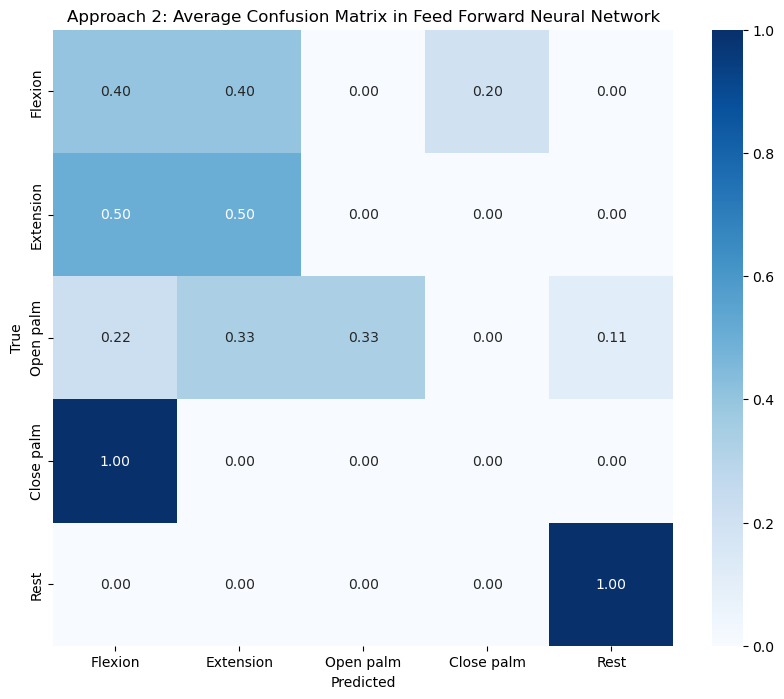

/tmp/ipykernel_79657/2198057562.py:44: RuntimeWarning: invalid value encountered in divide
  conf_matrix_percent = conf_matrix / total_samples_per_class[:, None]


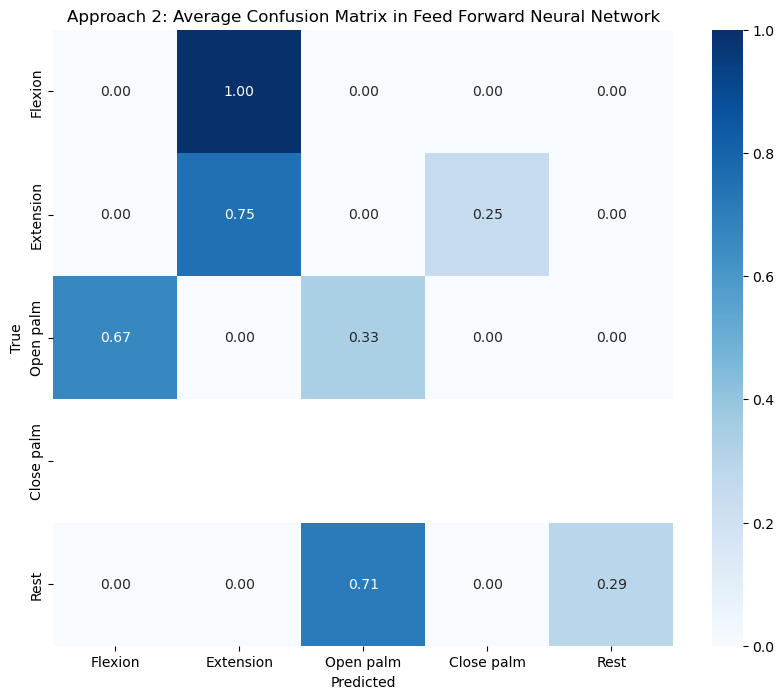

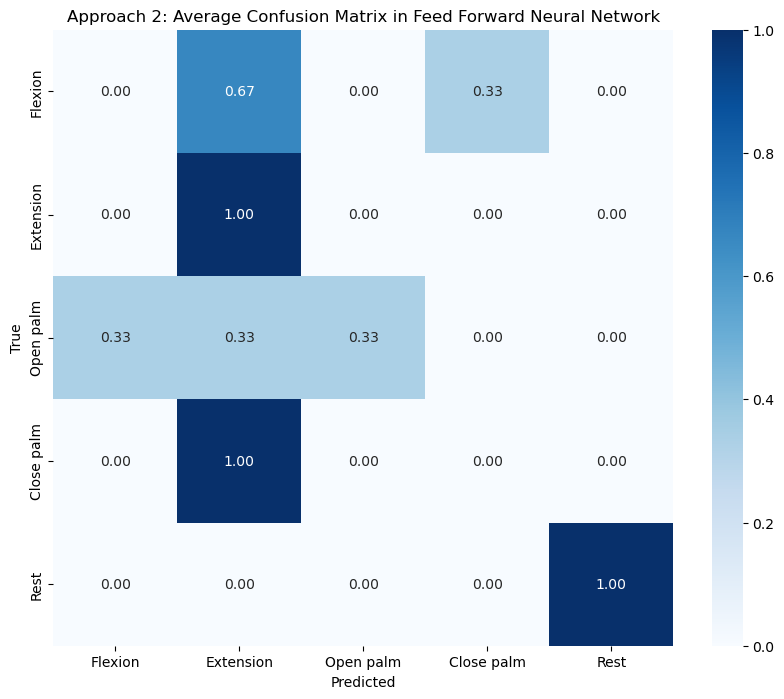

/tmp/ipykernel_79657/2198057562.py:44: RuntimeWarning: invalid value encountered in divide
  conf_matrix_percent = conf_matrix / total_samples_per_class[:, None]


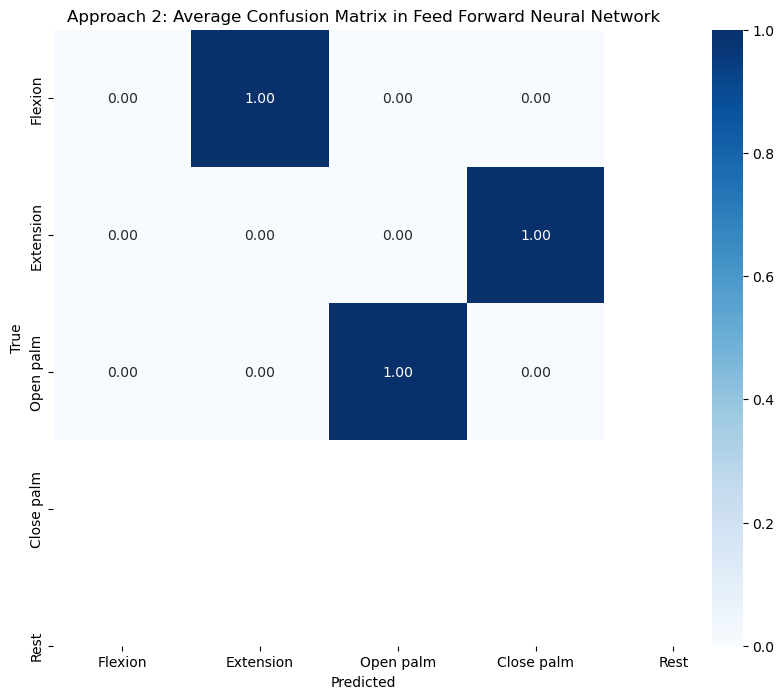

/tmp/ipykernel_79657/2198057562.py:44: RuntimeWarning: invalid value encountered in divide
  conf_matrix_percent = conf_matrix / total_samples_per_class[:, None]


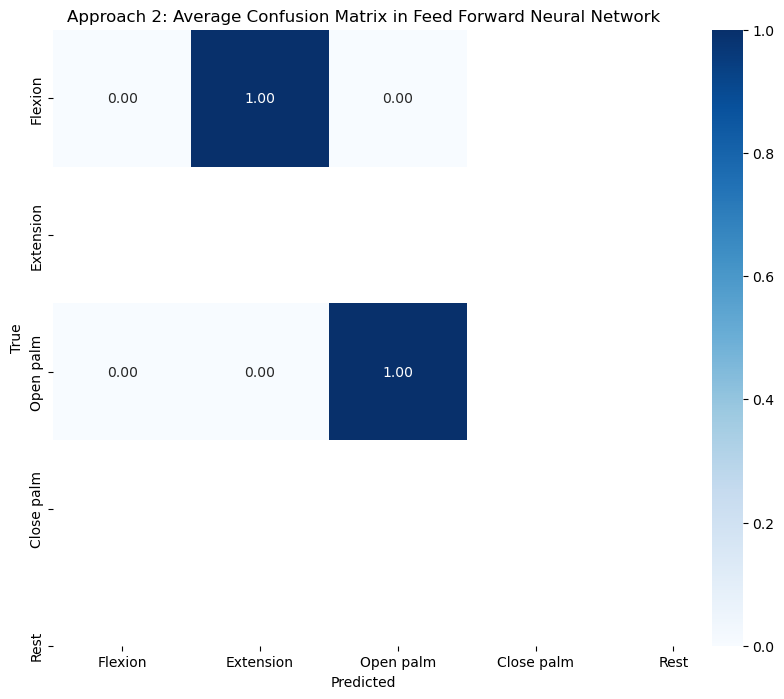

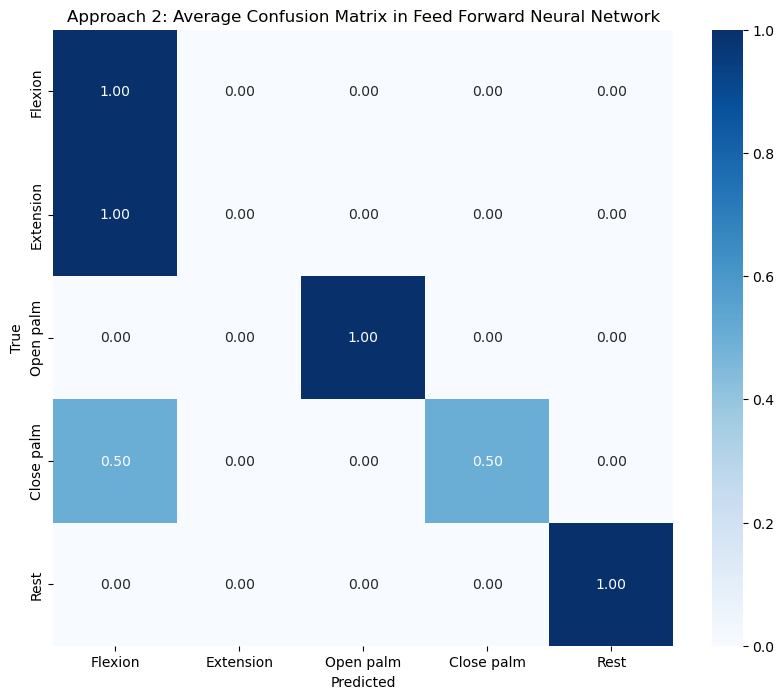

In [7]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

class_names = ['Flexion', 'Extension', 'Open palm', 'Close palm', 'Rest']
# Initialize variables to accumulate predictions and true labels
# Initialize variables to accumulate predictions and true labels
conf_matrices_FFNN_s2 = []

# Loop through shifts and folds
for shift in range(9):

    # Load the trained model
    modelWOoperator = FFNN(40, 9)
    modelWOoperator.load_state_dict(torch.load(f"modelwoOperator_fshift_{shift}_app2_5motions_full_features.pt"))
    modelWOoperator.eval()

    # Prepare the test dataset
    test_shift_dataset = CustomSignalData(get_tensor(X_test[shift]), get_tensor(y_test[shift]))
    test_shift_loader = torch.utils.data.DataLoader(test_shift_dataset, batch_size=24, shuffle=True)

    with torch.no_grad():
        for inputs, labels,_,_ in test_shift_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            pred = modelWOoperator(inputs)
            predicted = torch.argmax(pred,dim = 1)
            # all_predictions.extend(predicted.tolist())
            # all_true_labels.extend(labels.tolist())


        # # Evaluate the model and accumulate predictions and true labels
        # predictions, true_labels = clf_predictions(modelWOoperator, test_shift_loader, encoder=None)
        # all_predictions.extend(predictions)
        # all_true_labels.extend(true_labels)
        
    # Calculate the confusion matrix for the current shift
    conf_matrix = confusion_matrix(labels.tolist(), predicted.tolist())
    conf_matrices_FFNN_s2.append(conf_matrix)

    total_samples_per_class = np.sum(conf_matrix, axis=1)
    conf_matrix_percent = conf_matrix / total_samples_per_class[:, None]

    # Plot the average confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_percent, annot=True, cmap='Blues', fmt='.2f', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Approach 2: Average Confusion Matrix in Feed Forward Neural Network')
    plt.show()

4. Self-supervised Learning

4.1 Training 

In [17]:
for shift in range(9):
    all_X_train, all_y_train, all_shift_train = get_all_data_full_feature(X_train[shift], y_train[shift])
    encoder = E(40,8)
    encoder.to(DEVICE)
    classifier = FFNN(8,9)
    classifier.to(DEVICE)

    parameters = list(encoder.parameters()) + list(classifier.parameters())

    crit1 = torch.nn.MSELoss()
    crit2 = torch.nn.CrossEntropyLoss()
    crit1.to(DEVICE)
    crit2.to(DEVICE)
    loss_record = []

    optimizer = torch.optim.Adam(parameters, lr=0.002)
    n_epochs = 50

    for epoch in range(0,n_epochs):
        encoder.train()
        classifier.train()
        for inputs1, inputs2, shift1, shift2, labels, _ in triplettrainloader_list_s2[shift]:
            inputs1 = inputs1.to(DEVICE)
            inputs2 = inputs2.to(DEVICE)
            shift1 = -shift1.int().flatten().to(DEVICE)
            shift2 = -shift2.int().flatten().to(DEVICE)
            labels = labels.long().flatten().to(DEVICE)
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            y1 = encoder(inputs1)
            y_tr_est1 = rotate_batch(y1,shift1,6)
            y_tr1 = classifier(y_tr_est1)


            y2 = encoder(inputs2)
            y_tr_est2 = rotate_batch(y2,shift2,6)
            y_tr2 = classifier(y_tr_est2)

            loss =  crit1(y_tr_est1, y_tr_est2) + 0.5*crit2(y_tr1,labels)+ 0.5*crit2(y_tr2,labels)
            loss.backward()
            optimizer.step()

    torch.save(classifier.state_dict(), f"classifier_shift_{shift}_app2_5motions_full_features.pt")
    torch.save(encoder.state_dict(), f"encoder_shift_{shift}_app2_5motions_full_features.pt")
    with torch.no_grad():
        encoder.eval()
        N_points = 1000
        rand_idx = np.random.choice(all_X_train.shape[0], N_points)
        y_tr = encoder(get_tensor(all_X_train[rand_idx]))
        recovered_points_ = rotate_batch(y_tr,-all_shift_train[rand_idx].flatten(), 6)
        del y_tr

    torch.save(recovered_points_, f"reference_points_shift_{shift}_app2_5motions_full_features.pt")

Testing 

In [8]:
DEVICE = torch.device("cpu") # operations is in CPU or GPU.
M = torch.diag(torch.ones(8)).roll(-1,1) # Create a diagnoise matrix then shift it to the right
used_bases = [torch.linalg.matrix_power(M,i).to(DEVICE) for i in range (8)] #

N_points = 1000

accuracies_self_supervised_list_s2 = [0  for _ in range(9)]

for shift in range(9):
    classifier = FFNN(8,9) # This indicates that the neural network expects input data with 8 features and will produce output predictions across 9 classes.
    encoder = E(40,8)
    encoder.load_state_dict(torch.load(f"encoder_shift_{shift}_app2_5motions_full_features.pt")) # contains the learned parameters (weights and biases) of the encoder model
    recovered_points_= torch.load(f"reference_points_shift_{shift}_app2_5motions_full_features.pt") # These points represent reference points for inference or evaluation in the model
    classifier.load_state_dict(torch.load(f"classifier_shift_{shift}_app2_5motions_full_features.pt")) # contains the weights and biases learned during training.
    classifier.eval() # sets the model to evaluation mode.
    encoder.eval() # sets the model to evaluation mode.

    # Get the test data for the current shift and fold
    X_test_shift = X_test[shift]

    # Encode the test data using the encoder model
    y1 = encoder(get_tensor(X_test_shift))

    # Use the encoded data directly without rotation
    y_tr1 = classifier(y1).argmax(1)

    # Calculate accuracy and append to list
    accuracies_self_supervised_list_s2[shift] = (1 - torch.abs(torch.sign(y_tr1 - get_tensor(y_test[shift]).flatten()))).mean().item()
for accuracy in accuracies_self_supervised_list_s2:
    print(accuracy)

0.4254671633243561
0.3991987407207489
0.32684990763664246
0.33400958776474
0.3446275293827057
0.2938025891780853
0.3693113923072815
0.32807424664497375
0.4220195412635803


In [9]:
print(accuracies_self_supervised_list_s2)

[0.4254671633243561, 0.3991987407207489, 0.32684990763664246, 0.33400958776474, 0.3446275293827057, 0.2938025891780853, 0.3693113923072815, 0.32807424664497375, 0.4220195412635803]


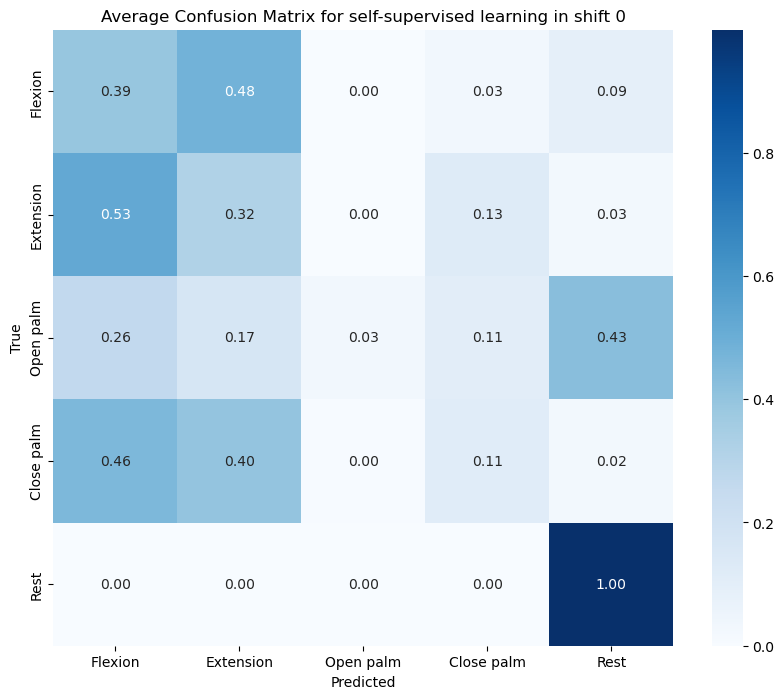

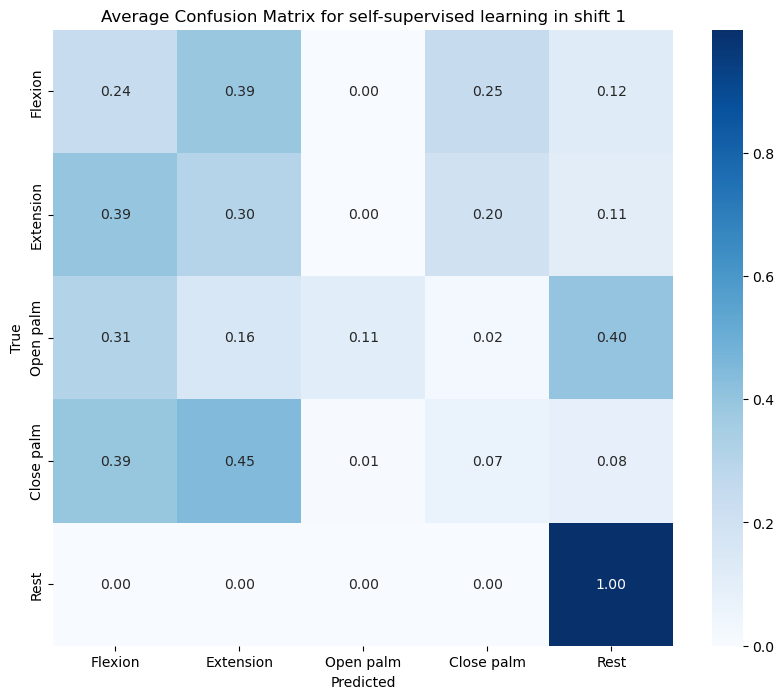

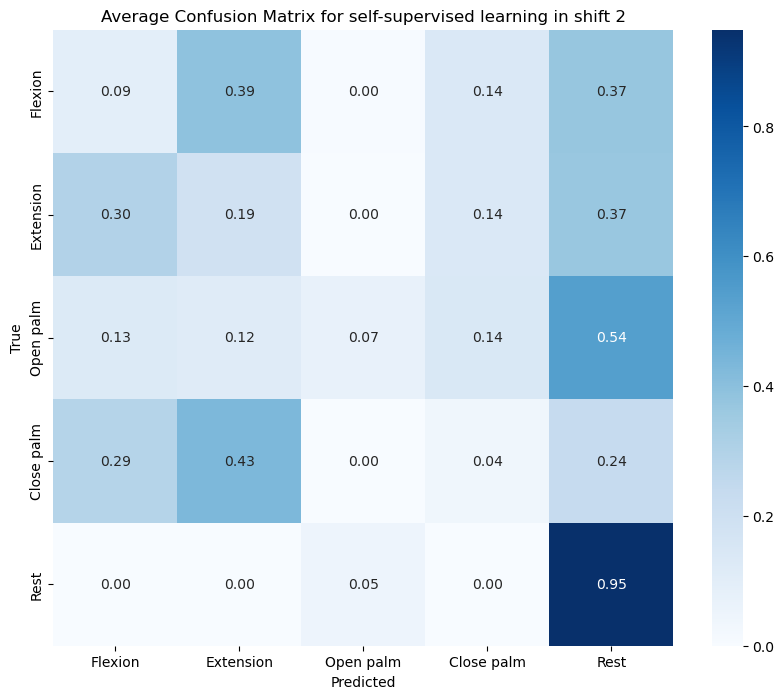

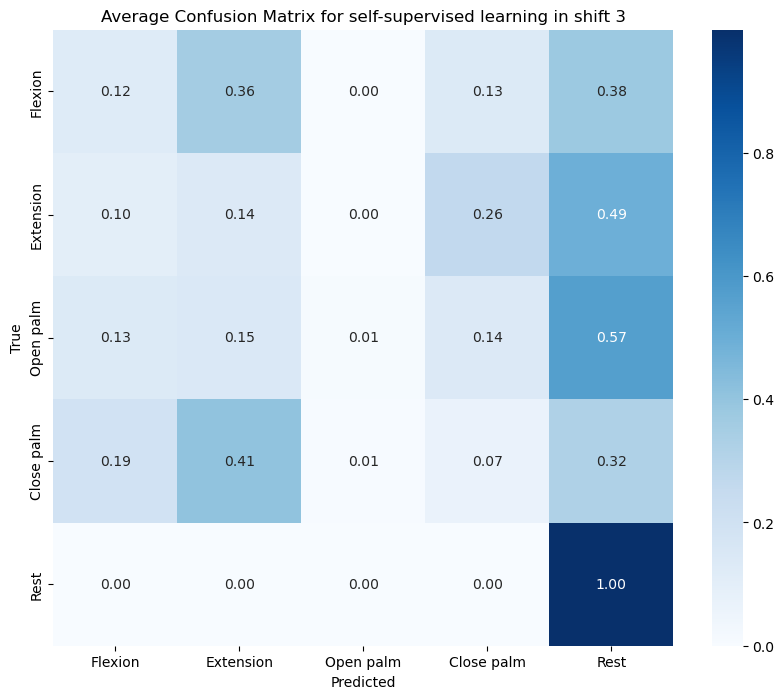

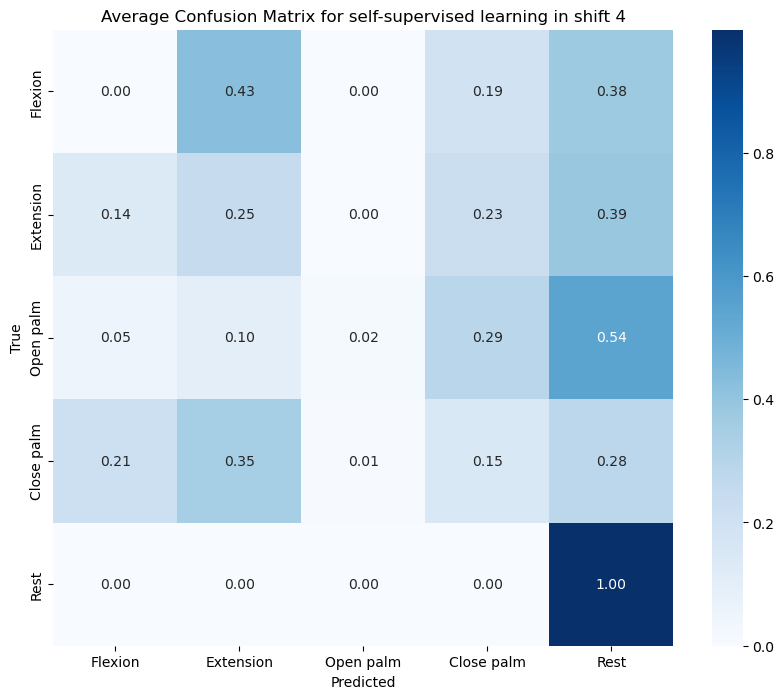

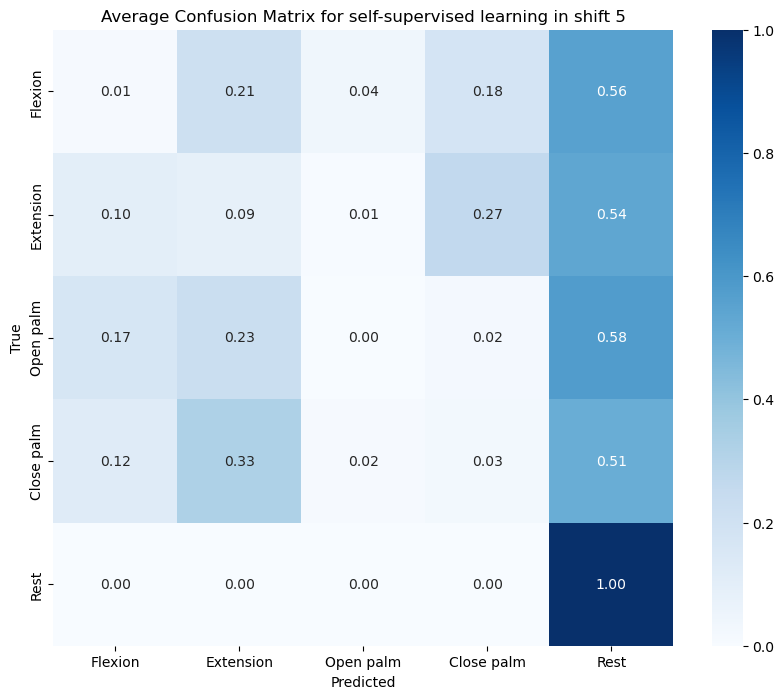

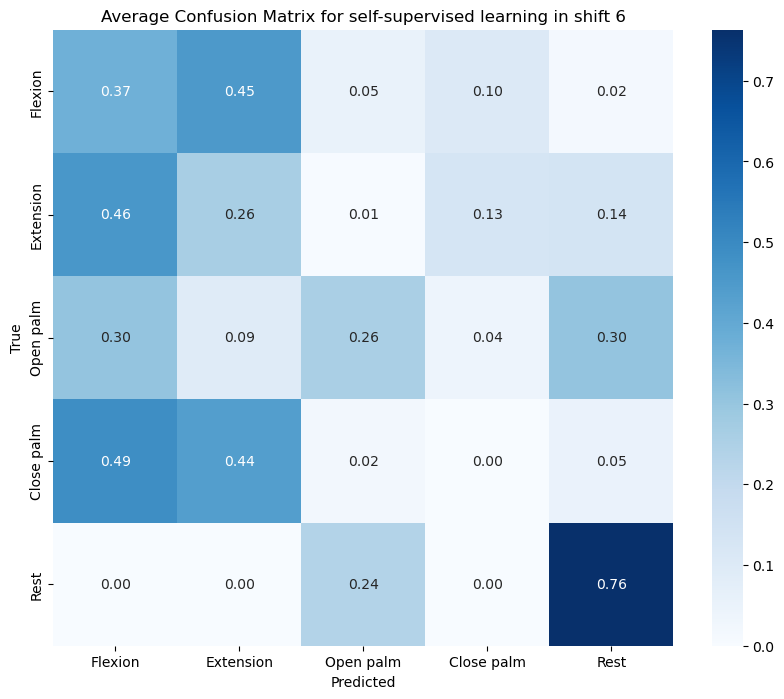

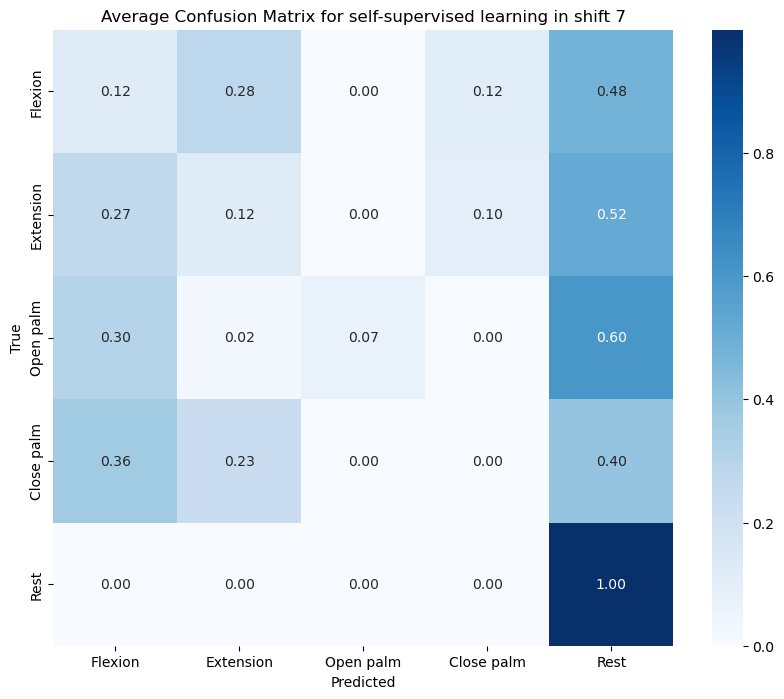

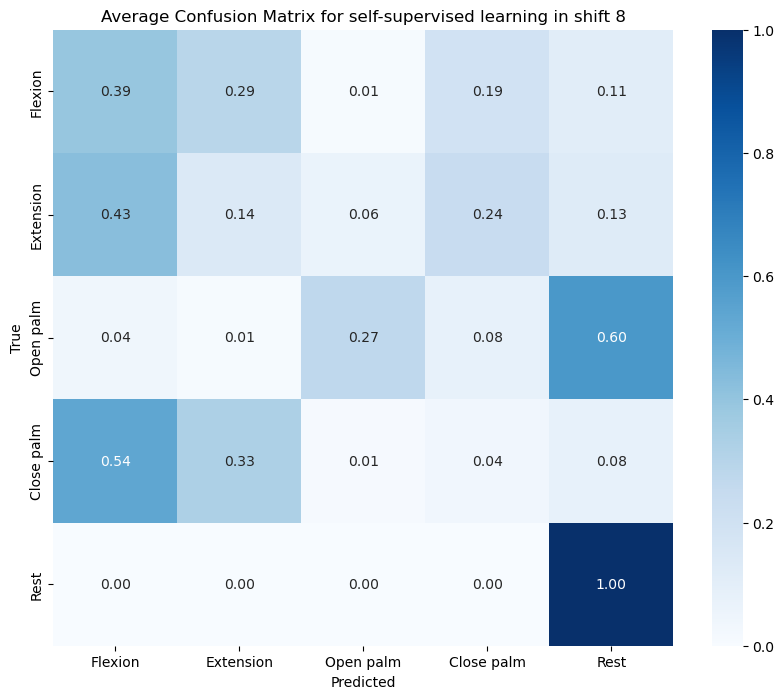

In [10]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Initialize variables to accumulate predictions and true labels
conf_matrices_self_supervised_s2 = []
class_names = ['Flexion', 'Extension', 'Open palm', 'Close palm', 'Rest']
# Loop through shifts and folds
for shift in range(9):

    #classifier = FFNN(8,9) # This indicates that the neural network expects input data with 8 features and will produce output predictions across 9 classes.
    encoder = E(40,8)
    encoder.load_state_dict(torch.load(f"encoder_shift_{shift}_app2_5motions_full_features.pt")) # contains the learned parameters (weights and biases) of the encoder model
    recovered_points_= torch.load(f"reference_points_shift_{shift}_app2_5motions_full_features.pt") # These points represent reference points for inference or evaluation in the model
    classifier.load_state_dict(torch.load(f"classifier_shift_{shift}_app2_5motions_full_features.pt")) # contains the weights and biases learned during training.
    classifier.eval() # sets the model to evaluation mode.
    encoder.eval() # sets the model to evaluation mode.

    # Get the test data for the current shift and fold
    X_test_shift = X_test[shift]
    # Encode the test data using the encoder model
    y1 = encoder(get_tensor(X_test_shift))
    # Use the encoded data directly without rotation
    y_tr1 = classifier(y1).argmax(1)

    # all_predictions.extend(y_tr1.cpu().numpy())
    # all_true_labels.extend(get_tensor(y_test[shift][k_fold]).flatten())

        
    # Calculate the confusion matrix for the current shift
    conf_matrix = confusion_matrix(get_tensor(y_test[shift]).flatten(), y_tr1.cpu().numpy())
    conf_matrices_self_supervised_s2.append(conf_matrix)

    total_samples_per_class = np.sum(conf_matrix, axis=1)
    conf_matrix_percent = conf_matrix / total_samples_per_class[:, None]

    # Plot the average confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_percent, annot=True, cmap='Blues', fmt='.2f', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Average Confusion Matrix for self-supervised learning in shift {shift}')
    plt.show()


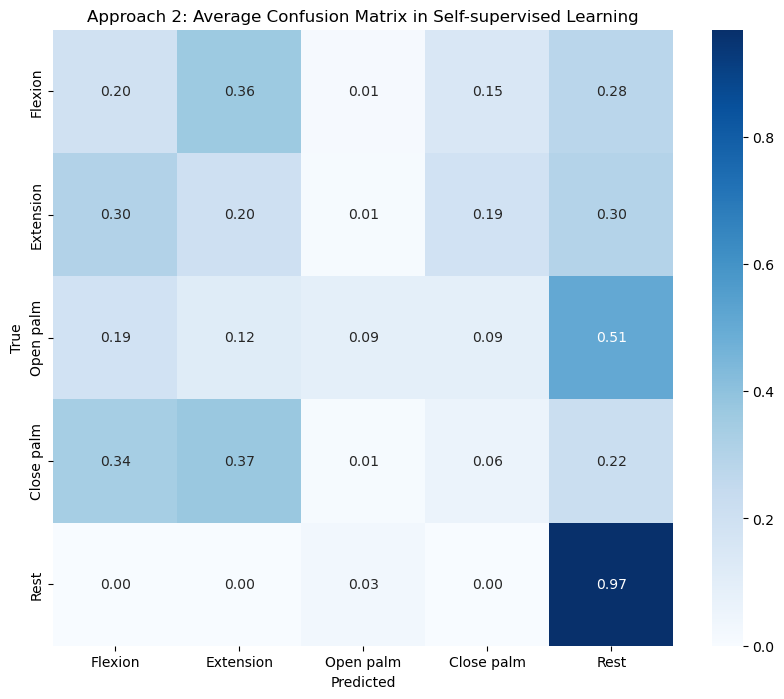

In [11]:
conf_matrices_self_supervised_s2 

average_conf_matrix__self_supervised = np.mean(conf_matrices_self_supervised_s2 , axis=0)
average_total__self_supervised_samples_per_class = np.sum(average_conf_matrix__self_supervised, axis=1)
average_conf__self_supervised_matrix_percent = average_conf_matrix__self_supervised / average_total__self_supervised_samples_per_class[:, None]
# Plot the average confusion matrix
plt.figure(figsize=(10, 8))

sns.heatmap(average_conf__self_supervised_matrix_percent, annot=True, cmap='Blues', fmt='.2f', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Approach 2: Average Confusion Matrix in Self-supervised Learning')
plt.show()

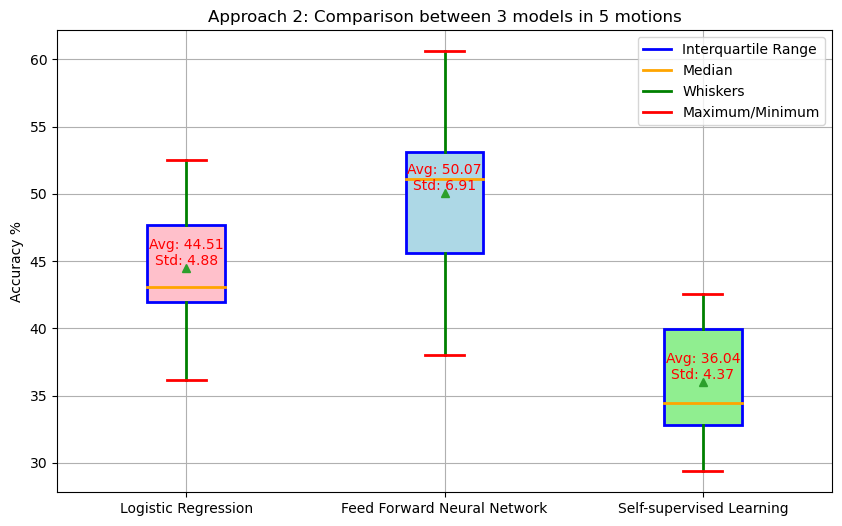

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Data
data = [
    [0.4769307094426989, 0.4307519120617157, 0.4366709668882935, 0.41938273247306107, 0.36140304346384644, 0.413991550513955, 0.5254411569590023, 0.42734504474643686, 0.5138108994125093],
    [0.5308496953239517, 0.5113756722098215, 0.5930224876318659, 0.5270351175299094, 0.3801483623713089, 0.44040201082587815, 0.46154866212876716, 0.4561804461756363, 0.6059800877563679],
    [0.4254671633243561, 0.3991987407207489, 0.32684990763664246, 0.33400958776474, 0.3446275293827057, 0.2938025891780853, 0.3693113923072815, 0.32807424664497375, 0.4220195412635803]
]
# Multiply all values by 100
data = [[value * 100 for value in lst] for lst in data]

# Calculate average and standard deviation
averages = [np.mean(lst) for lst in data]
std_devs = [np.std(lst) for lst in data]

# Plot boxplot with customized colors and statistics
plt.figure(figsize=(10, 6))
colors = ['pink', 'lightblue', 'lightgreen']
boxprops = dict(color="blue", linewidth=2)
medianprops = dict(color="orange", linewidth=2)
whiskerprops = dict(color="green", linewidth=2)
capprops = dict(color="red", linewidth=2)
box = plt.boxplot(data, showmeans=True, patch_artist=True, boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops)

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)


plt.xticks([1, 2, 3], ['Logistic Regression', 'Feed Forward Neural Network', 'Self-supervised Learning'])
plt.ylabel('Accuracy %')
plt.title('Approach 2: Comparison between 3 models in 5 motions')
plt.grid(True)

# Add average and standard deviation text
for i in range(len(data)):
    plt.text(i + 1, averages[i], f'Avg: {averages[i]:.2f}\nStd: {std_devs[i]:.2f}', horizontalalignment='center', verticalalignment='bottom', fontsize=10, color='red')

# Add legend explaining box components
legend_elements = [
    plt.Line2D([0], [0], color='blue', lw=2, label='Interquartile Range'),
    plt.Line2D([0], [0], color='orange', lw=2, label='Median'),
    plt.Line2D([0], [0], color='green', lw=2, label='Whiskers'),
    plt.Line2D([0], [0], color='red', lw=2, label='Maximum/Minimum')
]
plt.legend(handles=legend_elements)

plt.show()


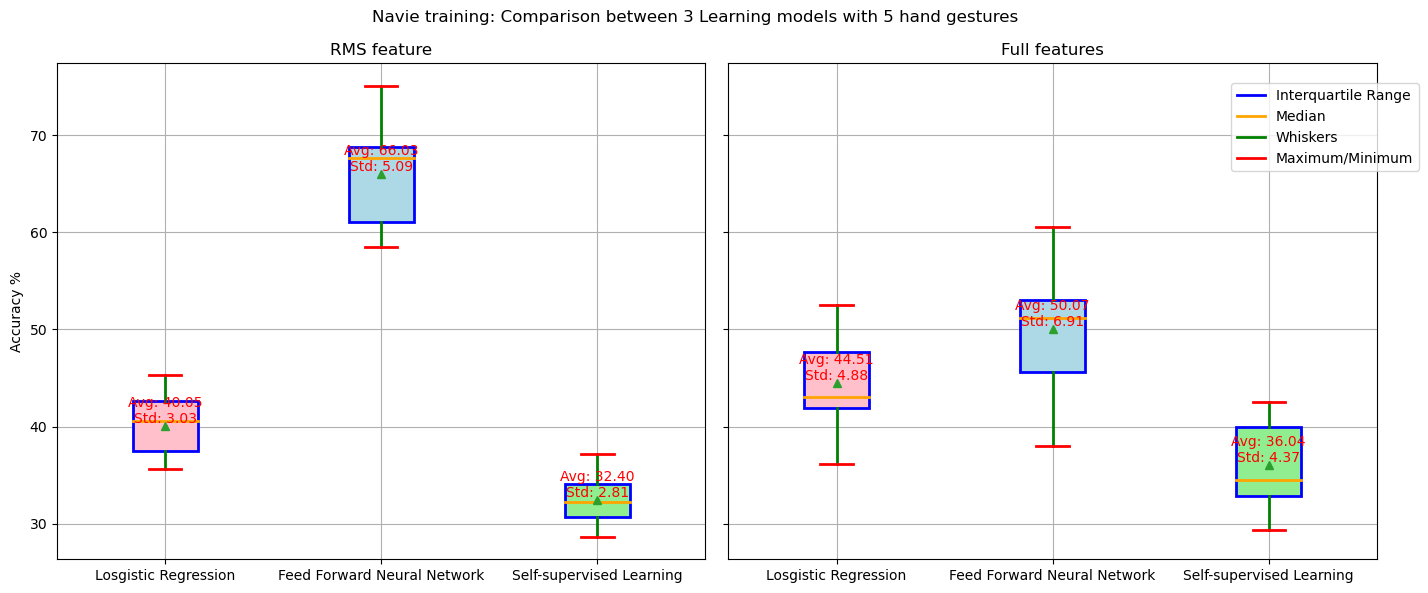

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# First dataset
data_2 = [
    [0.4769307094426989, 0.4307519120617157, 0.4366709668882935, 0.41938273247306107, 0.36140304346384644, 0.413991550513955, 0.5254411569590023, 0.42734504474643686, 0.5138108994125093],
    [0.5308496953239517, 0.5113756722098215, 0.5930224876318659, 0.5270351175299094, 0.3801483623713089, 0.44040201082587815, 0.46154866212876716, 0.4561804461756363, 0.6059800877563679],
    [0.4254671633243561, 0.3991987407207489, 0.32684990763664246, 0.33400958776474, 0.3446275293827057, 0.2938025891780853, 0.3693113923072815, 0.32807424664497375, 0.4220195412635803]
]


# Second dataset
data_1 = [
    [0.425967610829738, 0.37041438623924944, 0.3796273214508289, 0.41129609460090244, 0.356034268686367, 0.37486747739320236, 0.4054121229067636, 0.45332751744765704, 0.42758513450474267],
    [0.6773255818872101, 0.6769370911761682, 0.7508408070412452, 0.7002887187652218, 0.5977289660245024, 0.6566317627567271, 0.6882762048843187, 0.6102703047306548, 0.5844658303060638],
    [0.340742826461792, 0.33319780230522156, 0.32194939255714417, 0.3718375563621521, 0.3068351149559021, 0.28896164894104004, 0.3064902126789093, 0.2866089344024658, 0.35916653275489807]
]

# Multiply all values by 100
data_1 = [[value * 100 for value in lst] for lst in data_1]
data_2 = [[value * 100 for value in lst] for lst in data_2]

# Calculate average and standard deviation for each dataset
averages_1 = [np.mean(lst) for lst in data_1]
std_devs_1 = [np.std(lst) for lst in data_1]

averages_2 = [np.mean(lst) for lst in data_2]
std_devs_2 = [np.std(lst) for lst in data_2]

# Plotting subplots with shared y-axis
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharey=True)

colors = ['pink', 'lightblue', 'lightgreen']
boxprops = dict(color="blue", linewidth=2)
medianprops = dict(color="orange", linewidth=2)
whiskerprops = dict(color="green", linewidth=2)
capprops = dict(color="red", linewidth=2)

# Plot for first dataset
box_1 = ax1.boxplot(data_1, showmeans=True, patch_artist=True, boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops)
for patch, color in zip(box_1['boxes'], colors):
    patch.set_facecolor(color)
ax1.set_xticks([1, 2, 3])
ax1.set_xticklabels(['Losgistic Regression', 'Feed Forward Neural Network', 'Self-supervised Learning'])
ax1.set_ylabel('Accuracy %')
ax1.set_title('RMS feature')
ax1.grid(True)

# Add average and standard deviation text for first dataset
for i in range(len(data_1)):
    ax1.text(i + 1, averages_1[i], f'Avg: {averages_1[i]:.2f}\nStd: {std_devs_1[i]:.2f}', horizontalalignment='center', verticalalignment='bottom', fontsize=10, color='red')

# Plot for second dataset
box_2 = ax2.boxplot(data_2, showmeans=True, patch_artist=True, boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops)
for patch, color in zip(box_2['boxes'], colors):
    patch.set_facecolor(color)
ax2.set_xticks([1, 2, 3])
ax2.set_xticklabels(['Losgistic Regression', 'Feed Forward Neural Network', 'Self-supervised Learning'])
ax2.set_title('Full features')
ax2.grid(True)

# Add average and standard deviation text for second dataset
for i in range(len(data_2)):
    ax2.text(i + 1, averages_2[i], f'Avg: {averages_2[i]:.2f}\nStd: {std_devs_2[i]:.2f}', horizontalalignment='center', verticalalignment='bottom', fontsize=10, color='red')

# Add legend explaining box components
legend_elements = [
    plt.Line2D([0], [0], color='blue', lw=2, label='Interquartile Range'),
    plt.Line2D([0], [0], color='orange', lw=2, label='Median'),
    plt.Line2D([0], [0], color='green', lw=2, label='Whiskers'),
    plt.Line2D([0], [0], color='red', lw=2, label='Maximum/Minimum')
]
fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.95, 0.7))


# Common title
fig.suptitle('Navie training: Comparison between 3 Learning models with 5 hand gestures')

plt.tight_layout()
plt.show()
